In [38]:
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [39]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(mean=0, stddev=0.01,
                                 shape=(num_inputs,num_outputs)))
b = tf.Variable(tf.zeros(num_outputs))

In [40]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

In [41]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition

In [42]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.277418  , 0.617557  , 0.02761807, 0.01021426, 0.0671927 ],
        [0.24114607, 0.23122208, 0.41644216, 0.06525712, 0.04593257]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

In [43]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X,(-1, W.shape[0])), W) + b)

In [44]:
y = tf.constant([0, 2])
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [45]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, 
                                        tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

In [46]:
# 预测类别与真实y元素进行比较
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

accuracy(y_hat, y)/len(y)

0.5

In [47]:
def evaluate_accuracy(net, data_iter):
    '''计算在指定数据集上模型的精度'''
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [49]:
class Accumulator:
    '''在n个变量上累加'''
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

0.058

In [50]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）。"""
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras内置的损失接受的是（标签，预测），这不同于用户在本书中的实现
            # 本书的实现接受（预测，标签），例如我们上面实现的“交叉熵”
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras的`loss`默认返回一个批量的平均损失
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

In [51]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [52]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [53]:
class Updater():  #@save
    """用小批量随机梯度下降法更新参数。"""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

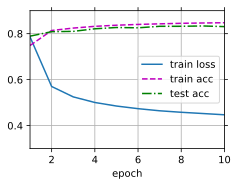

In [54]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [56]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)